## CSCE 580- Final Exam
### Shruti Jadhav
#### Question 2- Attendance Audit System (Post-processing and Analysis)

In [1]:
#First we import the necessary libraries
import os
import re
import pandas as pd
from datetime import datetime
import numpy as np

DATA_DIR = "./attendance_csv" # Directory containing attendance CSV files

In [3]:
# Function to parse filename
def parse_filename(filename): 
    """
    Extract class number and date from filename.
    Handles duplicates (..._v2).
    Returns (class_number, date, is_duplicate).
    """
    base = filename.replace(".csv", "") # Remove file extension
    
    # Pattern for ClassX_YYYY-MM-DD or ClassX_YYYY-MM-DD_v2
    match = re.match(r"Class(\d+)_(\d{4}-\d{2}-\d{2})(?:_(v\d+))?$", base)
    
    if not match:
        return None, None, False
    
    class_num = int(match.group(1)) # Extract class number
    date_str = match.group(2) # Extract date string
    duplicate_flag = match.group(3) is not None # Check for duplicate flag
    
    date = datetime.strptime(date_str, "%Y-%m-%d").date() # Convert to date object
    
    return class_num, date, duplicate_flag 

# Load files from directory
files = [f for f in os.listdir(DATA_DIR) if f.endswith(".csv")]

records = [] # List to hold file metadata
for f in files: 
    class_num, date, is_dup = parse_filename(f) # Parse filename
    if class_num is None: # Unrecognized filename format
        print(" Skipped unrecognized file:", f)
        continue
    records.append({ # Store metadata
        "filename": f,
        "class_number": class_num,
        "date": date,
        "duplicate": is_dup
    })

file_df = pd.DataFrame(records) # Create DataFrame from records
file_df.sort_values("class_number", inplace=True) # Sort by class number
file_df.reset_index(drop=True, inplace=True) # Reset index

In [ ]:
# Here is the resulting DataFrame that shows extracted class number and dates (including duplicate flags)
file_df

,filename,class_number,date,duplicate
0,Class1_2025-08-19.csv,1,2025-08-19,False
1,Class2_2025-08-21.csv,2,2025-08-21,False
2,Class3_2025-08-26.csv,3,2025-08-26,False
3,Class4_2025-08-28.csv,4,2025-08-28,False
4,Class5_2025-09-02.csv,5,2025-09-02,False
5,Class6_2025-09-04.csv,6,2025-09-04,False
6,Class7_2025-09-09.csv,7,2025-09-09,False
7,Class8_2025-09-11.csv,8,2025-09-11,False
8,Class9_2025-09-16.csv,9,2025-09-16,False
9,Class10_2025-09-18.csv,10,2025-09-18,False


In [5]:
# Now we read and consolidate all CSV files into a single master DataFrame
all_data = []

for _, row in file_df.iterrows():
    df = pd.read_csv(os.path.join(DATA_DIR, row.filename))
    # Normalize date format from mm/dd/yyyy → datetime.date
    df["ParsedDate"] = pd.to_datetime(df["date"], format="%Y-%m-%d", errors="coerce").dt.date
    
    df["ClassNumber"] = row.class_number
    df["ClassDate"] = row.date
    df["Duplicate"] = row.duplicate
    
    all_data.append(df)

master_df = pd.concat(all_data, ignore_index=True)

master_df.head()

,number,name,username,class,date,ParsedDate,ClassNumber,ClassDate,Duplicate
0,1,Lilian Lamb,llamb,Class 1,8/19/2025,NaT,1,2025-08-19,False
1,2,Luke Peter,mp79,Class 1,8/19/2025,NaT,1,2025-08-19,False
2,3,Gavin Orme,Gorme,Class 1,8/19/2025,NaT,1,2025-08-19,False
3,4,Charlie Gomman,gormance,Class 1,8/19/2025,NaT,1,2025-08-19,False
4,5,Kyle Hix,khix,Class 1,8/19/2025,NaT,1,2025-08-19,False


In [8]:
# Finally, we clean any potential duplicate files by retaining the version with larger attendance
clean_df = master_df.copy()

for dup_class in file_df[file_df.duplicate].class_number.unique(): # Iterate over classes with duplicates
    versions = master_df[master_df["ClassNumber"] == dup_class] # Get both versions for this class

    # Compare attendance sizes
    counts = versions.groupby("Duplicate").size() # Count entries per version

    # If v2 smaller → drop v2
    if counts.get(True, 0) < counts.get(False, 0):
        clean_df = clean_df[~((clean_df.ClassNumber == dup_class) & (clean_df.Duplicate == True))] # Drop v2
    else:
        clean_df = clean_df[~((clean_df.ClassNumber == dup_class) & (clean_df.Duplicate == False))] # Drop v1

clean_df.shape

(871, 9)

#### Now the post processing of the data is done. We can now move to do data analysis

In [10]:
# Now we can analyze the cleaned data, e.g., count attendance per class session
attendance = (
    clean_df.groupby(["ClassNumber", "ClassDate"]) # Group by class number and date
    .size() # Get size of each group
    .reset_index(name="AttendanceCount") # Count attendance
)

attendance.sort_values("ClassNumber", inplace=True) # Sort by class number

#Here we have the final attendance count per class session
attendance 


,ClassNumber,ClassDate,AttendanceCount
0,1,2025-08-19,44
1,2,2025-08-21,49
2,3,2025-08-26,45
3,4,2025-08-28,30
4,5,2025-09-02,40
5,6,2025-09-04,40
6,7,2025-09-09,42
7,8,2025-09-11,34
8,9,2025-09-16,33
9,10,2025-09-18,31


## Now we can answer the questions:

#### Q1- The following is the list of class and their dates

In [ ]:
#To answer question #1: 
class_list = attendance[["ClassNumber", "ClassDate"]]
print(class_list)

    ClassNumber   ClassDate
0             1  2025-08-19
1             2  2025-08-21
2             3  2025-08-26
3             4  2025-08-28
4             5  2025-09-02
5             6  2025-09-04
6             7  2025-09-09
7             8  2025-09-11
8             9  2025-09-16
9            10  2025-09-18
10           11  2025-09-28
11           12  2025-09-25
12           13  2025-09-30
13           14  2025-10-02
14           15  2025-10-07
15           16  2025-10-14
16           17  2025-10-16
17           18  2025-10-21
18           19  2025-10-23
19           20  2025-10-28
20           21  2025-10-30
21           22  2025-11-04
22           24  2025-11-11
23           25  2025-11-13
24           26  2025-11-18
25           27  2025-11-20


#### Q2- The following is the median attendance per class

In [11]:
median_attendance = attendance["AttendanceCount"].median()
print("median attendance per class:", median_attendance)


median attendance per class: 33.0


#### Q3 - The following are the dates with the lowest and highest attendance

In [12]:
low = attendance["AttendanceCount"].min()
high = attendance["AttendanceCount"].max()

low_date = attendance.loc[attendance["AttendanceCount"] == low, "ClassDate"].iloc[0]
high_date = attendance.loc[attendance["AttendanceCount"] == high, "ClassDate"].iloc[0]

print("Lowest attendance of", low, "students on", low_date)
print("Highest attendance of", high, "students on", high_date)

Lowest attendance of 14 students on 2025-11-20
Highest attendance of 49 students on 2025-08-21


#### Q4- The following shows the correlation of attendance with evaluation dates

In [13]:
evaluation_dates = {
    datetime(2025, 10, 7).date(): "Quiz 2",
    datetime(2025, 11, 11).date(): "Quiz 3",
    datetime(2025, 11, 18).date(): "Presentations"
}

attendance["IsEvaluation"] = attendance["ClassDate"].isin(evaluation_dates.keys())
attendance["EvaluationType"] = attendance["ClassDate"].map(evaluation_dates)

attendance_eval = attendance[attendance.IsEvaluation]
attendance_eval


,ClassNumber,ClassDate,AttendanceCount,IsEvaluation,EvaluationType
14,15,2025-10-07,45,True,Quiz 2
22,24,2025-11-11,41,True,Quiz 3
24,26,2025-11-18,34,True,Presentations


In [17]:
#Out of all evaluation dates, the following date had the highest attendance-
attendance_eval.loc[attendance_eval.AttendanceCount.idxmax()]

ClassNumber                15
ClassDate          2025-10-07
AttendanceCount            45
IsEvaluation             True
EvaluationType         Quiz 2
Name: 14, dtype: object

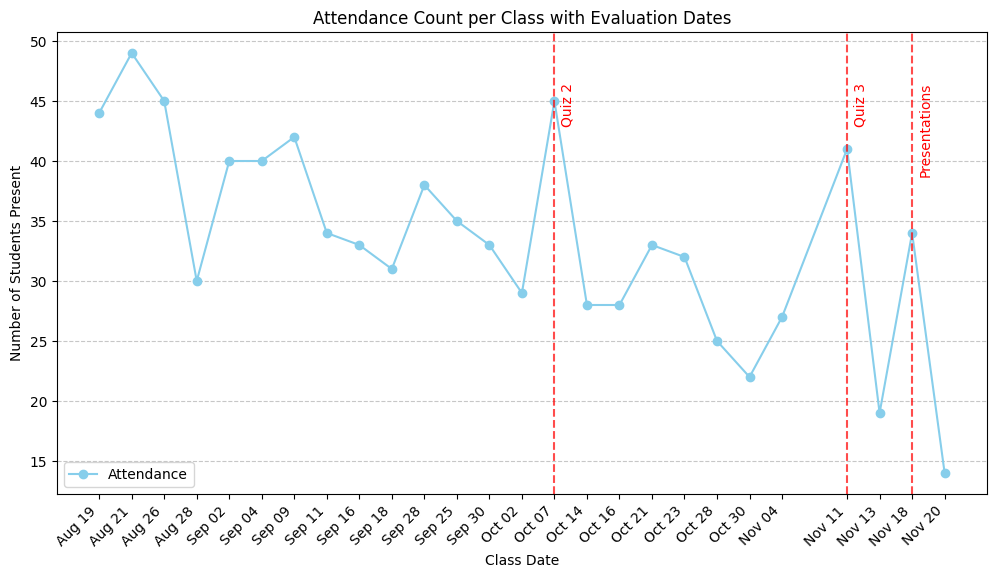

In [18]:
#Here is a graph to visualize attendance over time with evaluation dates marked

import matplotlib.pyplot as plt
import pandas as pd

# Ensure ClassNumber is integer and sorted
attendance['ClassNumber'] = attendance['ClassNumber'].astype(int)
attendance['ClassDate'] = pd.to_datetime(attendance['ClassDate'])
attendance = attendance.sort_values('ClassNumber')

# Define evaluation dates
evaluation_dates = {
    "Quiz 2": pd.to_datetime("2025-10-07"),
    "Quiz 3": pd.to_datetime("2025-11-11"),
    "Presentations": pd.to_datetime("2025-11-18")
}

# Find ClassNumber corresponding to each evaluation date
eval_class_numbers = {}
for name, date in evaluation_dates.items():
    closest_class = attendance.iloc[(attendance['ClassDate'] - date).abs().argsort()[0]]['ClassNumber']
    eval_class_numbers[name] = closest_class

# Plot line with markers
plt.figure(figsize=(12,6))
plt.plot(attendance['ClassNumber'], attendance['AttendanceCount'], marker='o', linestyle='-', color='skyblue', label='Attendance')

# Add vertical lines for evaluation dates
for eval_name, class_num in eval_class_numbers.items():
    plt.axvline(x=class_num, color='red', linestyle='--', alpha=0.7)
    plt.text(class_num + 0.2, max(attendance['AttendanceCount']) * 0.95, eval_name, rotation=90, color='red', verticalalignment='top')

# The following two lines can be uncommented if you want to see class dates on x-axis
# Add class date labels below the class numbers
date_labels = attendance["ClassDate"].dt.strftime("%b %d")   # e.g., "Aug 19"
plt.xticks(attendance["ClassNumber"], date_labels, rotation=45, ha="right")

plt.xlabel('Class Date')
plt.ylabel('Number of Students Present')
plt.title('Attendance Count per Class with Evaluation Dates')
plt.xticks(attendance['ClassNumber'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.show()
